# Install stan

In [1]:
# Install cmdstanpy module
!pip install cmdstanpy

# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install git+https://github.com/OriolAbril/arviz.git@ci

# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan(compiler=True)

!pip install --upgrade arviz
!pip install --upgrade cmdstanpy

  Cloning https://github.com/OriolAbril/arviz.git (to revision ci) to /tmp/pip-req-build-4f_4w7m0
  Running command git clone --filter=blob:none --quiet https://github.com/OriolAbril/arviz.git /tmp/pip-req-build-4f_4w7m0
  Running command git checkout -b ci --track origin/ci
  Switched to a new branch 'ci'
  Branch 'ci' set up to track remote branch 'ci' from 'origin'.
  Resolved https://github.com/OriolAbril/arviz.git to commit 7c20182c25b0b5e9af8242d1ee4d1185ae82b70a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for arviz: filename=arviz-0.17.0.dev0-py3-none-any.whl size=1651459 sha256=90e4642096e5d392c454169b39c8c903709e1b5ca95fde7484802dc36f85ac6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tgwus0_/wheels/46/1e/6c/46b9c646a79d4a0f01b37df1c2c0abcc4e7129fe66e88e9b0f
Successfully built arviz
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Unin

DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.34.1
Building version cmdstan-2.34.1, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.34.1
Test model compilation
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.17.0.dev0
    Uninstalling arviz-0.17.0.dev0:
      Successfully uninstalled arviz-0.17.0.dev0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import os

from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("/content/drive/My Drive/Bayesian/stan"):
    os.mkdir("/content/drive/My Drive/Bayesian/stan")

# Data preparation

In [6]:
# Import data
data = pd.read_csv('/content/drive/My Drive/Bayesian/All_values_Clean.csv')
data.head(5)

,Unnamed: 0,Id_sensor,Time,NOx,max_wind10,avg_wind10,max_wind100,avg_wind100,max_humidity,avg_humidity,...,sin12,cos12,sin6,cos6,sin4,cos4,sin3,cos3,lat,lng
0,7145,6204,gennaio 16,5.094537,-0.883564,-1.033000,-0.448047,-0.632854,0.614262,0.775022,...,0.500,0.866,0.866,0.5,1,0,0.866,-0.5,45.519335,9.59201
1,7146,6204,febbraio 16,4.847209,-0.160893,-0.054538,0.083888,0.459680,-0.152361,0.826117,...,0.866,0.500,0.866,-0.5,0,-1,-0.866,-0.5,45.519335,9.59201
2,7147,6204,marzo 16,3.911859,0.257496,-0.447750,0.367014,-0.273935,-0.152361,0.137046,...,1.000,0.000,0.000,-1.0,-1,0,0.000,1.0,45.519335,9.59201
3,7148,6204,aprile 16,3.763297,-0.984991,-0.200262,-0.928504,-0.113883,-1.685606,-0.319251,...,0.866,-0.500,-0.866,-0.5,0,1,0.866,-0.5,45.519335,9.59201
4,7149,6204,maggio 16,3.808000,-0.718744,-0.524298,-0.413729,-0.419238,-0.152361,-0.147897,...,0.500,-0.866,-0.866,0.5,1,0,-0.866,-0.5,45.519335,9.59201


In [7]:
unique_values_count = data['Id_sensor'].nunique()

print(f'The number of unique values in the Id_sensor column is: {unique_values_count}')

The number of unique values in the Id_sensor column is: 75


In [8]:
selected_columns = data[['Id_sensor','Time', 'NOx']]
print(selected_columns)

      Id_sensor          Time       NOx
0          6204    gennaio 16  5.094537
1          6204   febbraio 16  4.847209
2          6204      marzo 16  3.911859
3          6204     aprile 16  3.763297
4          6204     maggio 16  3.808000
...         ...           ...       ...
7045      30162     giugno 23  2.918380
7046      30162     luglio 23  2.802844
7047      30162     agosto 23  2.899084
7048      30162  settembre 23  2.765598
7049      30162    ottobre 23  3.381531

[7050 rows x 3 columns]


# Second model
y --> N(mu(t), sigma) \\
sigma --> estimated from the sample \\

mu(t)=e if t<s \\
mu(t)=l if t>s \\

e --> N(0,1) \\
l--> N(0,1) \\
s--> U(1..T) \\

In [22]:
secondmodel = """
functions {

    // Computes vector of lp
    vector compute_logp(array[] real obs, real early_rate, real late_rate, real sigma){

        // Deduce size of data and uniform contribution
        int T = size(obs);
        real log_unif = -log(T);

        // Compute contributions vector and return
        vector[T] lp = rep_vector(log_unif, T);
        for (s in 1:T) {
            for (t in 1:T) {
                lp[s] += normal_lpdf(obs[t] | t < s ? early_rate : late_rate, sigma);
            }
        }
        return lp;

    }

    // Computes the vector of probabilites for the posterior distribution of s
    vector compute_probs(vector lp) {
        return softmax(lp);
    }

    // Computes the marginal likelihood lpdf
    real marginal_likelihood_logpdf(vector lp){
        return log_sum_exp(lp);
    }

}

data {
    int<lower=1> T; //dimension of the time series
    array[T] real y; //array of y
    real <lower=0> sigma;
}

transformed data {
    real log_unif = -log(T);
}

parameters {
    real e;
    real l;
    }

model {
    // Likelihood
    target += marginal_likelihood_logpdf(compute_logp(y, e, l, sigma));

    // Prior
    e ~ normal(0,1);
    l ~ normal(0,1);
}

generated quantities {
    int<lower=1, upper=T> s = categorical_rng(compute_probs(compute_logp(y,e,l, sigma)));
}
"""

# Write stan model to file
stan_file = "/content/drive/My Drive/Bayesian/stan/secondmodel.stan"
with open(stan_file, "w") as f:
    print(secondmodel, file=f)

# Compile stan model
secondmodel = CmdStanModel(stan_file=stan_file)

08:18:02 - cmdstanpy - INFO - compiling stan file /tmp/tmp39p547nq/tmpbkh2kvex.stan to exe file /content/drive/My Drive/Bayesian/stan/secondmodel
INFO:cmdstanpy:compiling stan file /tmp/tmp39p547nq/tmpbkh2kvex.stan to exe file /content/drive/My Drive/Bayesian/stan/secondmodel
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=secondmodel.stan /tmp/tmp39p547nq/tmpbkh2kvex
cwd: /root/.cmdstan/cmdstan-2.34.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=secondmodel.stan --o=/tmp/tmp39p547nq/tmpbkh2kvex.hpp /tmp/tmp39p547nq/tmpbkh2kvex.stan

--- Compiling C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.81.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/s

In [11]:
unique_ids = selected_columns['Id_sensor'].unique()

In [12]:
import random
random.seed(10)


# Seleziona 15 campioni casuali
random_samples = random.sample(list(unique_ids), 20)

# **applied on the first half of the time series** (done)

In [13]:
random_samples2 = random.sample(list(unique_ids), 15)

In [14]:
selected_columns

,Id_sensor,Time,NOx
0,6204,gennaio 16,5.094537
1,6204,febbraio 16,4.847209
2,6204,marzo 16,3.911859
3,6204,aprile 16,3.763297
4,6204,maggio 16,3.808000
...,...,...,...
7045,30162,giugno 23,2.918380
7046,30162,luglio 23,2.802844
7047,30162,agosto 23,2.899084
7048,30162,settembre 23,2.765598


In [15]:
# Define the list of selected months
selected_months = ['gennaio 16', 'febbraio 16', 'marzo 16', 'aprile 16', 'maggio 16', 'giugno 16', 'luglio 16', 'agosto 16',
                   'settembre 16', 'ottobre 16', 'novembre 16', 'dicembre 16', 'gennaio 17', 'febbraio 17', 'marzo 17',
                   'aprile 17', 'maggio 17', 'giugno 17', 'luglio 17', 'agosto 17', 'settembre 17', 'ottobre 17', 'novembre 17',
                   'dicembre 17', 'gennaio 18', 'febbraio 18', 'marzo 18', 'aprile 18', 'maggio 18', 'giugno 18', 'luglio 18',
                   'agosto 18', 'settembre 18', 'ottobre 18', 'novembre 18', 'dicembre 18', 'gennaio 19', 'febbraio 19', 'marzo 19',
                   'aprile 19', 'maggio 19', 'giugno 19', 'luglio 19', 'agosto 19', 'settembre 19', 'ottobre 19', 'novembre 19',
                   'dicembre 19', 'gennaio 20', 'febbraio 20', 'marzo 20', 'aprile 20', 'maggio 20', 'giugno 20', 'luglio 20',
                   'agosto 20', 'settembre 20', 'ottobre 20', 'novembre 20', 'dicembre 20', 'gennaio 21']

# Use .isin() to filter the rows
filtered_df = selected_columns[selected_columns['Time'].isin(selected_months)]

# Print the filtered DataFrame
print(filtered_df)


      Id_sensor          Time       NOx
0          6204    gennaio 16  5.094537
1          6204   febbraio 16  4.847209
2          6204      marzo 16  3.911859
3          6204     aprile 16  3.763297
4          6204     maggio 16  3.808000
...         ...           ...       ...
7012      30162  settembre 20  3.299656
7013      30162    ottobre 20  3.919739
7014      30162   novembre 20  4.452783
7015      30162   dicembre 20  4.716516
7016      30162    gennaio 21  4.534347

[4575 rows x 3 columns]


In [16]:
subset_df = filtered_df[filtered_df['Id_sensor'] == 6328]

In [17]:
subset_df

,Id_sensor,Time,NOx
1974,6328,gennaio 16,5.376907
1975,6328,febbraio 16,5.043503
1976,6328,marzo 16,4.742156
1977,6328,aprile 16,4.543442
1978,6328,maggio 16,4.658050
...,...,...,...
2030,6328,settembre 20,4.245688
2031,6328,ottobre 20,4.796582
2032,6328,novembre 20,5.153578
2033,6328,dicembre 20,5.112038


In [18]:
subset_df.shape[0]

61

In [ ]:
9804

In [19]:
random_samples2

[6300,
 6817,
 6864,
 9917,
 6408,
 6398,
 10017,
 6330,
 6419,
 6831,
 30162,
 10451,
 9804,
 9920,
 6276]

In [23]:
def find_maxima(df):
    maxima_info = []

    # Iterate over each unique Id_sensor value
    for id_sensor in random_samples2:
        # Select subset for current Id_sensor
        subset_df = filtered_df[filtered_df['Id_sensor'] == id_sensor]

        # Perform analysis similar to your code
        cpc_data = {
            "T": subset_df.shape[0],
            "y": subset_df.NOx,
            "sigma": subset_df['NOx'].var()
        }


        # Algorithm parameters
        algo_params = {
            "n_chains": 4,
            "n_burnin": 1000,
            "n_iter": 5000
        }

        # Sample
        cpc_fit = secondmodel.sample(data=cpc_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                          iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])
        # Convert to arviz data type
        chains = az.InferenceData(posterior=cpc_fit.draws_xr())
        s_chain = np.hstack(chains.posterior.s).astype(int)
        x, y = np.unique(s_chain, return_counts=True)
        print(y)
        print(id_sensor)
        print("Primo massimo: {0}".format(subset_df['Time'].iloc[x[y == y.max()]].to_numpy().squeeze()))
        sorted_indices = np.argsort(-y)
        # Seleziona il secondo massimo
        second_max_index = sorted_indices[1]
        print("Secondo massimo: {0}".format(subset_df['Time'].iloc[x[second_max_index]]))

        maxima_info.append((id_sensor, subset_df['Time'].iloc[x[y == y.max()]], subset_df['Time'].iloc[x[second_max_index]]))

    return maxima_info

maxima_secondmodel_split1 = find_maxima(filtered_df)

# Create dataframes for maxima information
#df_maxima_1 = pd.DataFrame(maxima_area_1, columns=['Id_sensor', 'Primo_massimo', 'Secondo_massimo'])
maxima_secondmodel_split1 = pd.DataFrame(maxima_secondmodel_split1, columns=['Id_sensor', 'Primo_massimo', 'Secondo_massimo'])

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/xml8ixiq.json
08:18:32 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=24008', 'data', 'file=/tmp/tmpvjuts47s/xml8ixiq.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelrrkwh5ry/secondmodel-20240209081832_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=24008', 'data', 'file=/tmp/tmpvjuts47s/xml8ixiq.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelrrkwh5ry/secondmodel-20240209081832_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:18:50 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=24008', 'data', 'file=/tmp/tmpvjuts47s/xml8ixiq.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelrrkwh5ry/secondmodel-20240209081832_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelrrkwh5ry/secondmodel-20240209081832_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelrrkwh5ry/secondmodel-20240209081832_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19951     1     1     1     1     2     4     2     1     2     1     1
     2     2     3     1     1     2     1     1     2     5     3     2
     2     1     1     1     1     1]
6300
Primo massimo: febbraio 16
Secondo massimo: maggio 19


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=27971', 'data', 'file=/tmp/tmpvjuts47s/xzdyxsmc.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel4d8t84o9/secondmodel-20240209081850_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=27971', 'data', 'file=/tmp/tmpvjuts47s/xzdyxsmc.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel4d8t84o9/secondmodel-20240209081850_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

08:19:08 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=27971', 'data', 'file=/tmp/tmpvjuts47s/xzdyxsmc.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel4d8t84o9/secondmodel-20240209081850_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel4d8t84o9/secondmodel-20240209081850_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel4d8t84o9/secondmodel-20240209081850_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[9460   49   29   27   16   17   15   20   41   39   24   17   10   23
   43   38   20   20   10   13    7   13   18   12   56  203  264  276
  194   94   46   25   12   13    8    7   44  169  990 2071  409   68
   72   36   24   14   20   15   53  479 1623 1271 1081  238   36   15
    9   21   24   24   15]
6817
Primo massimo: febbraio 16
Secondo massimo: maggio 19


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=99480', 'data', 'file=/tmp/tmpvjuts47s/6ajh3skw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelf4t7olx6/secondmodel-20240209081908_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=99480', 'data', 'file=/tmp/tmpvjuts47s/6ajh3skw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelf4t7olx6/secondmodel-20240209081908_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:19:28 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=99480', 'data', 'file=/tmp/tmpvjuts47s/6ajh3skw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelf4t7olx6/secondmodel-20240209081908_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelf4t7olx6/secondmodel-20240209081908_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelf4t7olx6/secondmodel-20240209081908_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19717    17    20    20    12     9     6    10    15    24    13     4
     1     6     8    10     4     2     3     2     1     4     2     2
     5     4     4     6     1     3     1     1     3     2     1     2
     3     3     2     2     4     1     2     3     2     2     2     2
     4     4     2     2     5     2     1     4     1     2]
6864
Primo massimo: febbraio 16
Secondo massimo: novembre 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=94821', 'data', 'file=/tmp/tmpvjuts47s/an30d92i.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeldjq46em6/secondmodel-20240209081928_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=94821', 'data', 'file=/tmp/tmpvjuts47s/an30d92i.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeldjq46em6/secondmodel-20240209081928_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

08:19:48 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=94821', 'data', 'file=/tmp/tmpvjuts47s/an30d92i.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeldjq46em6/secondmodel-20240209081928_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodeldjq46em6/secondmodel-20240209081928_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodeldjq46em6/secondmodel-20240209081928_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19813    17    12    10     5     3     6     2     2     4     1     3
     5    10    12     5     2     3     1     5     1     3     3     2
     1     2     2     2     4     2     5     3     4     4     3     2
     4     1     1     1     1     1     3     5     6     5     1     2
     4     1]
9917
Primo massimo: febbraio 16
Secondo massimo: marzo 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=78025', 'data', 'file=/tmp/tmpvjuts47s/ji8d1lc2.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelgsk4q64i/secondmodel-20240209081949_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=78025', 'data', 'file=/tmp/tmpvjuts47s/ji8d1lc2.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelgsk4q64i/secondmodel-20240209081949_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

08:20:07 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=78025', 'data', 'file=/tmp/tmpvjuts47s/ji8d1lc2.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelgsk4q64i/secondmodel-20240209081949_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelgsk4q64i/secondmodel-20240209081949_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelgsk4q64i/secondmodel-20240209081949_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19447   211   113    16     6     2     2     2     4     5     2     1
     3    10    36    42     9     2     3     3     2     4     4     2
     4     5     4     1     2     1     2     1     3     1     3     2
     1     3     1     3     2     3     1     6     3     2     1     1
     2     1     2     1     3     1     1     2]
6408
Primo massimo: febbraio 16
Secondo massimo: marzo 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=28716', 'data', 'file=/tmp/tmpvjuts47s/z4m5x0b7.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodell6sdxebh/secondmodel-20240209082007_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=28716', 'data', 'file=/tmp/tmpvjuts47s/z4m5x0b7.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodell6sdxebh/secondmodel-20240209082007_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:20:25 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=28716', 'data', 'file=/tmp/tmpvjuts47s/z4m5x0b7.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodell6sdxebh/secondmodel-20240209082007_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodell6sdxebh/secondmodel-20240209082007_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodell6sdxebh/secondmodel-20240209082007_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19539     7     9     1    10     5     9     5     8    10     6     4
     4     5    11     9     6     7     7     7     6     3     2     5
     7    13    20    20    13    10     8     6     7     4     2     5
     8     9    23    26    17     7     6     4     4     5     8     6
     8     6    12     7     6     6     2     5     3     4     5     8
     5]
6398
Primo massimo: febbraio 16
Secondo massimo: maggio 19


08:20:25 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=90618', 'data', 'file=/tmp/tmpvjuts47s/8duqew52.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelv02o6_00/secondmodel-20240209082025_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=90618', 'data', 'file=/tmp/tmpvjuts47s/8duqew52.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelv02o6_00/secondmodel-20240209082025_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:20:56 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=90618', 'data', 'file=/tmp/tmpvjuts47s/8duqew52.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelv02o6_00/secondmodel-20240209082025_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelv02o6_00/secondmodel-20240209082025_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelv02o6_00/secondmodel-20240209082025_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/z74eb_n3.json
08:20:56 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


[19055    40    64    57    28    15    12    14    31    48    32    11
    14    10    15    17    15    11     4     7    11    20    11    10
    15    11    14    19     8     9     7     6    10     9     9     9
    10    16    14    11    15    13    13     7    14    14    14    16
     5     9    10    13    15     8    12    14    17    19    20    12
    11]
10017
Primo massimo: febbraio 16
Secondo massimo: aprile 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=92434', 'data', 'file=/tmp/tmpvjuts47s/z74eb_n3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel08vnc127/secondmodel-20240209082056_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=92434', 'data', 'file=/tmp/tmpvjuts47s/z74eb_n3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel08vnc127/secondmodel-20240209082056_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:21:14 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=92434', 'data', 'file=/tmp/tmpvjuts47s/z74eb_n3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel08vnc127/secondmodel-20240209082056_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel08vnc127/secondmodel-20240209082056_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel08vnc127/secondmodel-20240209082056_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19932     4     3     4     1     2     1     1     2     3     3     4
     3     1     2     1     1     2     2     2     1     3     2     1
     1     1     2     1     2     2     1     1     3     2     1     1
     1]
6330
Primo massimo: febbraio 16
Secondo massimo: marzo 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=68510', 'data', 'file=/tmp/tmpvjuts47s/ubt4myhw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodela78a2pcs/secondmodel-20240209082114_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=68510', 'data', 'file=/tmp/tmpvjuts47s/ubt4myhw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodela78a2pcs/secondmodel-20240209082114_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

08:21:31 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=68510', 'data', 'file=/tmp/tmpvjuts47s/ubt4myhw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodela78a2pcs/secondmodel-20240209082114_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodela78a2pcs/secondmodel-20240209082114_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodela78a2pcs/secondmodel-20240209082114_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19437     5     6     6     5     7    30   125   196    62    13     4
     4     1     1     4     1     4     3     2     2     5     3     2
     1     3     2     1     3     3     2     2     3     5     3     1
     2     3     4     2     3     1     2     1     4     2     2     2
     1     2     2     3     2     2     2     1]
6419
Primo massimo: febbraio 16
Secondo massimo: novembre 16


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=92250', 'data', 'file=/tmp/tmpvjuts47s/1h5qhg29.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelznfbd5j5/secondmodel-20240209082131_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=92250', 'data', 'file=/tmp/tmpvjuts47s/1h5qhg29.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelznfbd5j5/secondmodel-20240209082131_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:22:04 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=92250', 'data', 'file=/tmp/tmpvjuts47s/1h5qhg29.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelznfbd5j5/secondmodel-20240209082131_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelznfbd5j5/secondmodel-20240209082131_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelznfbd5j5/secondmodel-20240209082131_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[15426    47    65    58    31    18    20    29    40    66    49    22
    17    26    48    63    49    27    13    21    22    11    19    13
    44    98   154   255   167    91    55    30    22    17    20    24
    51    98   207   278   212   130    88    64    34    22    25    23
    35   128   296   251   127    55    43    44    81   170   178   114
    69]
6831
Primo massimo: febbraio 16
Secondo massimo: aprile 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=69014', 'data', 'file=/tmp/tmpvjuts47s/tgqyg5nw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel8tqd8673/secondmodel-20240209082205_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=69014', 'data', 'file=/tmp/tmpvjuts47s/tgqyg5nw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel8tqd8673/secondmodel-20240209082205_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:22:22 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=69014', 'data', 'file=/tmp/tmpvjuts47s/tgqyg5nw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel8tqd8673/secondmodel-20240209082205_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel8tqd8673/secondmodel-20240209082205_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel8tqd8673/secondmodel-20240209082205_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19369    11     8    10     9     4     1    10    10    14     7     8
     5    12    33    33    23    22     6     4     6     3     3     3
    10    19    31    42    20    12    10     2     5     3     4    14
    31    36    20    20    10     6     2     1     2     5     4     7
    21    24    10     3     3     1     3     1     2     2]
30162
Primo massimo: febbraio 16
Secondo massimo: maggio 18


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=35680', 'data', 'file=/tmp/tmpvjuts47s/dshj66g3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel5y6sljic/secondmodel-20240209082223_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=35680', 'data', 'file=/tmp/tmpvjuts47s/dshj66g3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel5y6sljic/secondmodel-20240209082223_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:22:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=35680', 'data', 'file=/tmp/tmpvjuts47s/dshj66g3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel5y6sljic/secondmodel-20240209082223_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel5y6sljic/secondmodel-20240209082223_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel5y6sljic/secondmodel-20240209082223_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19586    25    37    26     6     2     6     2     8    10     8     5
     6     4     6     4     3     8     1     4     1     4     3     3
     8     7    11    12     9     4     5     4     1     4     2     8
    14    22    22    10     9     4     5     3     2     3     4     2
     3     7     4     2     4     4     8    12     3     5     2     3]
10451
Primo massimo: febbraio 16
Secondo massimo: aprile 16


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=49276', 'data', 'file=/tmp/tmpvjuts47s/6oi9ezzx.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelwsddxn3c/secondmodel-20240209082242_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=49276', 'data', 'file=/tmp/tmpvjuts47s/6oi9ezzx.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelwsddxn3c/secondmodel-20240209082242_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:22:59 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=49276', 'data', 'file=/tmp/tmpvjuts47s/6oi9ezzx.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelwsddxn3c/secondmodel-20240209082242_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelwsddxn3c/secondmodel-20240209082242_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelwsddxn3c/secondmodel-20240209082242_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19322    51    29    18    12    17    12    17    21    32    29    24
     9    10     9     8    12     6     3    11    13    12     5     6
     6    17    18    20    12    11     9     5     7     4     9     3
     8    16    20    27    14    12     6     6     2     2     6     1
     4    11     5    15     4     3     6     7     2     3     3     4
     4]
9804
Primo massimo: febbraio 16
Secondo massimo: marzo 16


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=27460', 'data', 'file=/tmp/tmpvjuts47s/nlamnwf7.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel1urx_ynk/secondmodel-20240209082300_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=27460', 'data', 'file=/tmp/tmpvjuts47s/nlamnwf7.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel1urx_ynk/secondmodel-20240209082300_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:23:20 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=27460', 'data', 'file=/tmp/tmpvjuts47s/nlamnwf7.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel1urx_ynk/secondmodel-20240209082300_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel1urx_ynk/secondmodel-20240209082300_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel1urx_ynk/secondmodel-20240209082300_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[18643    16    17    11     2     8    20    43   138   138   121    57
    17     6     7     2     5    10     9     5    13     8     8     3
     5     6    18    22    11    11     7     3     6     3     2     3
     9    21    47    81    63    30    11    11    10    11     6     4
     9    22    71    73    37    18     9     4     7    18     9     8
     7]
9920
Primo massimo: febbraio 16
Secondo massimo: ottobre 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=88875', 'data', 'file=/tmp/tmpvjuts47s/y1itvfo5.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelazyeoa4g/secondmodel-20240209082320_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=88875', 'data', 'file=/tmp/tmpvjuts47s/y1itvfo5.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelazyeoa4g/secondmodel-20240209082320_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:23:39 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=88875', 'data', 'file=/tmp/tmpvjuts47s/y1itvfo5.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelazyeoa4g/secondmodel-20240209082320_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelazyeoa4g/secondmodel-20240209082320_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelazyeoa4g/secondmodel-20240209082320_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[19920     4    11     6     4     2     2     6     5     1     2     1
     2     1     1     1     3     2     1     1     1     1     1     1
     2     5     1     1     1     2     3     1     1     1     1     1]
6276
Primo massimo: febbraio 16
Secondo massimo: aprile 16


# **applied on the second half of the time series**

In [24]:
# Define the list of selected months
selected_months_2 = ['maggio 20', 'giugno 20', 'luglio 20', 'agosto 20', 'settembre 20', 'ottobre 20', 'novembre 20',
                     'dicembre 20', 'gennaio 21', 'febbraio 21', 'marzo 21', 'aprile 21', 'maggio 21', 'giugno 21',
                     'luglio 21', 'agosto 21', 'settembre 21', 'ottobre 21', 'novembre 21', 'dicembre 21', 'gennaio 22',
                     'febbraio 22', 'marzo 22', 'aprile 22', 'maggio 22', 'giugno 22', 'luglio 22', 'agosto 22',
                     'settembre 22', 'ottobre 22', 'novembre 22', 'dicembre 22', 'gennaio 23', 'febbraio 23',
                     'marzo 23', 'aprile 23', 'maggio 23', 'giugno 23', 'luglio 23', 'agosto 23', 'settembre 23',
                     'ottobre 23']

# Use .isin() to filter the rows
filtered_df_2 = selected_columns[selected_columns['Time'].isin(selected_months_2)]

# Print the filtered DataFrame
print(filtered_df_2)


      Id_sensor          Time       NOx
52         6204     maggio 20  3.100334
53         6204     giugno 20  3.198091
54         6204     luglio 20  3.164377
55         6204     agosto 20  3.290701
56         6204  settembre 20  3.497653
...         ...           ...       ...
7045      30162     giugno 23  2.918380
7046      30162     luglio 23  2.802844
7047      30162     agosto 23  2.899084
7048      30162  settembre 23  2.765598
7049      30162    ottobre 23  3.381531

[3150 rows x 3 columns]


In [42]:
def find_maxima(df):
    maxima_info = []

    # Iterate over each unique Id_sensor value
    for id_sensor in random_samples2:
        # Select subset for current Id_sensor
        subset_df = filtered_df_2[filtered_df_2['Id_sensor'] == id_sensor]

       # Perform analysis similar to your code
        cpc_data = {
            "T": subset_df.shape[0],
            "y": subset_df.NOx,
            "sigma": subset_df['NOx'].var()
        }


        # Algorithm parameters
        algo_params = {
            "n_chains": 4,
            "n_burnin": 1000,
            "n_iter": 5000
        }

        # Sample
        cpc_fit = secondmodel.sample(data=cpc_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                          iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])
        # Convert to arviz data type
        chains = az.InferenceData(posterior=cpc_fit.draws_xr())
        s_chain = np.hstack(chains.posterior.s).astype(int)
        x, y = np.unique(s_chain, return_counts=True)
        print(y)
        print(id_sensor)
        print("Primo massimo: {0}".format(subset_df['Time'].iloc[x[y == y.max()]].to_numpy().squeeze()))
        sorted_indices = np.argsort(-y)
        # Seleziona il secondo massimo
        second_max_index = sorted_indices[1]
        print("Secondo massimo: {0}".format(subset_df['Time'].iloc[x[second_max_index]]))

        maxima_info.append((id_sensor, subset_df['Time'].iloc[x[y == y.max()]], subset_df['Time'].iloc[x[second_max_index]]))

    return maxima_info

maxima_secondmodel_split2 = find_maxima(filtered_df)

# Create dataframes for maxima information
#df_maxima_1 = pd.DataFrame(maxima_area_1, columns=['Id_sensor', 'Primo_massimo', 'Secondo_massimo'])
maxima_secondmodel_split2 = pd.DataFrame(maxima_secondmodel_split2, columns=['Id_sensor', 'Primo_massimo', 'Secondo_massimo'])

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/ltan0vkr.json
09:38:04 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=61837', 'data', 'file=/tmp/tmpvjuts47s/ltan0vkr.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelfp022ngo/secondmodel-20240209093804_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=61837', 'data', 'file=/tmp/tmpvjuts47s/ltan0vkr.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelfp022ngo/secondmodel-20240209093804_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:38:16 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=61837', 'data', 'file=/tmp/tmpvjuts47s/ltan0vkr.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelfp022ngo/secondmodel-20240209093804_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelfp022ngo/secondmodel-20240209093804_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelfp022ngo/secondmodel-20240209093804_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[11755   720   734   666  1454   564    74     4     3     3     2     4
     5     3     2     1     1     1     4     2     5    16     8     9
     6     3     2     3     2    10    38   319  1038  1290   986   199
    35     8    21]
6300
Primo massimo: giugno 20
Secondo massimo: ottobre 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=52452', 'data', 'file=/tmp/tmpvjuts47s/vmn9_nhu.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelw0s829vr/secondmodel-20240209093816_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=52452', 'data', 'file=/tmp/tmpvjuts47s/vmn9_nhu.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelw0s829vr/secondmodel-20240209093816_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:38:24 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=52452', 'data', 'file=/tmp/tmpvjuts47s/vmn9_nhu.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelw0s829vr/secondmodel-20240209093816_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelw0s829vr/secondmodel-20240209093816_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelw0s829vr/secondmodel-20240209093816_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/i4kjgh17.json
09:38:24 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


[   43     3    13    50  1771 17724   358     3     1     1     1     1
     2     2     3     1     1     3     8     7     2     2]
6817
Primo massimo: novembre 20
Secondo massimo: ottobre 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=33665', 'data', 'file=/tmp/tmpvjuts47s/i4kjgh17.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeln_vom3zg/secondmodel-20240209093824_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=33665', 'data', 'file=/tmp/tmpvjuts47s/i4kjgh17.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeln_vom3zg/secondmodel-20240209093824_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

09:38:40 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=33665', 'data', 'file=/tmp/tmpvjuts47s/i4kjgh17.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeln_vom3zg/secondmodel-20240209093824_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodeln_vom3zg/secondmodel-20240209093824_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodeln_vom3zg/secondmodel-20240209093824_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[8387   84  130  419 3669 5056  835   38    4    7    7   10    7    4
    3    3    5   14   11    7    2    2    9   16   18    3    6    4
    3    4    3    2    6   26  114  625  322   80   36   10    4    5]
6864
Primo massimo: giugno 20
Secondo massimo: novembre 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=72428', 'data', 'file=/tmp/tmpvjuts47s/s97d3v8w.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelgukiw2bl/secondmodel-20240209093840_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=72428', 'data', 'file=/tmp/tmpvjuts47s/s97d3v8w.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelgukiw2bl/secondmodel-20240209093840_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:38:55 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=72428', 'data', 'file=/tmp/tmpvjuts47s/s97d3v8w.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelgukiw2bl/secondmodel-20240209093840_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelgukiw2bl/secondmodel-20240209093840_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelgukiw2bl/secondmodel-20240209093840_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[2859  641  991 2661 8517 2262   56    2    1    1    1    2    1    1
    2    2    3    1    2    3    8    8    6    1    1    1    4   15
  238 1027  536  100   34    2    2    8]
9917
Primo massimo: ottobre 20
Secondo massimo: giugno 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=75789', 'data', 'file=/tmp/tmpvjuts47s/lkfoltmm.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelag05m4yz/secondmodel-20240209093855_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=4', 'random', 'seed=75789', 'data', 'file=/tmp/tmpvjuts47s/lkfoltmm.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelag05m4yz/secondmodel-20240209093855_4.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

09:39:05 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=75789', 'data', 'file=/tmp/tmpvjuts47s/lkfoltmm.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelag05m4yz/secondmodel-20240209093855_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelag05m4yz/secondmodel-20240209093855_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelag05m4yz/secondmodel-20240209093855_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[6719    2    1  121  978 2168   10    2    2   19  512 1721 7741    4]
6408
Primo massimo: maggio 23
Secondo massimo: giugno 20


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/usddggmn.json
09:39:06 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=53457', 'data', 'file=/tmp/tmpvjuts47s/usddggmn.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel9ki_ux5m/secondmodel-20240209093906_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=53457', 'data', 'file=/tmp/tmpvjuts47s/usddggmn.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel9ki_ux5m/secondmodel-20240209093906_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

09:39:17 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=53457', 'data', 'file=/tmp/tmpvjuts47s/usddggmn.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel9ki_ux5m/secondmodel-20240209093906_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel9ki_ux5m/secondmodel-20240209093906_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel9ki_ux5m/secondmodel-20240209093906_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[4172  719  672 1359 6339 5189  425   23    3    3    2    1    1    2
    4    5   10    4    4    6    3    7    4    3    4    4    1    2
    1    5    8   37  160  349  269  126   54   11    4    5]
6398
Primo massimo: ottobre 20
Secondo massimo: novembre 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=538', 'data', 'file=/tmp/tmpvjuts47s/sjwdxhvi.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel26uly1lt/secondmodel-20240209093918_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=538', 'data', 'file=/tmp/tmpvjuts47s/sjwdxhvi.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel26uly1lt/secondmodel-20240209093918_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 

09:39:32 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=538', 'data', 'file=/tmp/tmpvjuts47s/sjwdxhvi.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel26uly1lt/secondmodel-20240209093918_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel26uly1lt/secondmodel-20240209093918_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel26uly1lt/secondmodel-20240209093918_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Defa


[ 667   74   37   14   31   14    7    3    2    3    5    4    1    2
    3    1    3    4    2    3    2   15   36   57   25   14    7    6
    2    3    2    2   25  227 2323 7394 5914 2371  545  120   22    8]
10017
Primo massimo: maggio 23
Secondo massimo: giugno 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=4997', 'data', 'file=/tmp/tmpvjuts47s/3_fvj4ba.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelzvdw9you/secondmodel-20240209093932_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=4997', 'data', 'file=/tmp/tmpvjuts47s/3_fvj4ba.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelzvdw9you/secondmodel-20240209093932_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random'

09:39:52 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=4997', 'data', 'file=/tmp/tmpvjuts47s/3_fvj4ba.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelzvdw9you/secondmodel-20240209093932_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelzvdw9you/secondmodel-20240209093932_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelzvdw9you/secondmodel-20240209093932_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Def

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/rkdqdwe9.json
09:39:52 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


[13375   245   200   258   442   219    47     7     8     4     8     6
     8     6     6     3     2     3     2     3    13    18    66   126
    94    48    23     9    10     3     3     2    20    96   572  1610
  1453   692   192    70    13    15]
6330
Primo massimo: giugno 20
Secondo massimo: maggio 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=80017', 'data', 'file=/tmp/tmpvjuts47s/rkdqdwe9.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelpmsgy4je/secondmodel-20240209093952_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=80017', 'data', 'file=/tmp/tmpvjuts47s/rkdqdwe9.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelpmsgy4je/secondmodel-20240209093952_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:40:14 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=80017', 'data', 'file=/tmp/tmpvjuts47s/rkdqdwe9.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelpmsgy4je/secondmodel-20240209093952_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelpmsgy4je/secondmodel-20240209093952_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelpmsgy4je/secondmodel-20240209093952_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[3788   71  110  296 1537  770   74   12    4    1   11   14    4    2
    3    5    5    4    2    6    5   11   43   63   34   13   12    7
    4    4    8   17  111 1155 7451 3659  525  126   17   11    5]
6419
Primo massimo: maggio 23
Secondo massimo: giugno 20


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/99yr31mr.json
09:40:14 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=9802', 'data', 'file=/tmp/tmpvjuts47s/99yr31mr.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelbjmt7w08/secondmodel-20240209094014_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=9802', 'data', 'file=/tmp/tmpvjuts47s/99yr31mr.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelbjmt7w08/secondmodel-20240209094014_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmo

09:40:23 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=9802', 'data', 'file=/tmp/tmpvjuts47s/99yr31mr.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelbjmt7w08/secondmodel-20240209094014_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelbjmt7w08/secondmodel-20240209094014_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelbjmt7w08/secondmodel-20240209094014_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Def


[ 194   13   35  325 7885 9724 1038   36    1    3    1    1    1    1
    2    2    2   11    7    3    2    1    1    1   19  154   86  324
  102   16    4    5]
6831
Primo massimo: novembre 20
Secondo massimo: ottobre 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=68940', 'data', 'file=/tmp/tmpvjuts47s/xbmh9ix4.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelvt8vwtjn/secondmodel-20240209094024_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=68940', 'data', 'file=/tmp/tmpvjuts47s/xbmh9ix4.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelvt8vwtjn/secondmodel-20240209094024_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:40:33 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=68940', 'data', 'file=/tmp/tmpvjuts47s/xbmh9ix4.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelvt8vwtjn/secondmodel-20240209094024_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelvt8vwtjn/secondmodel-20240209094024_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelvt8vwtjn/secondmodel-20240209094024_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[ 369  107  180  952 5230 2948  206    1    1    1    2    1    2    1
    2    2    1    1    4    5    3    1    3    4   40  467 2474 3755
 2464  651   93   28    1]
30162
Primo massimo: ottobre 20
Secondo massimo: giugno 23


09:40:33 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=9297', 'data', 'file=/tmp/tmpvjuts47s/tlbshz4j.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel0jtzh4df/secondmodel-20240209094033_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=9297', 'data', 'file=/tmp/tmpvjuts47s/tlbshz4j.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel0jtzh4df/secondmodel-20240209094033_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmo

09:40:43 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=9297', 'data', 'file=/tmp/tmpvjuts47s/tlbshz4j.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel0jtzh4df/secondmodel-20240209094033_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel0jtzh4df/secondmodel-20240209094033_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel0jtzh4df/secondmodel-20240209094033_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Def

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/bzt68fdg.json
09:40:43 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


[    1     1     1    10    54    22     8     3     4    97  1269 11958
  6171   327    66     7     1]
10451
Primo massimo: maggio 23
Secondo massimo: giugno 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=47815', 'data', 'file=/tmp/tmpvjuts47s/bzt68fdg.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodels5lcclil/secondmodel-20240209094043_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=47815', 'data', 'file=/tmp/tmpvjuts47s/bzt68fdg.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodels5lcclil/secondmodel-20240209094043_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:41:02 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=47815', 'data', 'file=/tmp/tmpvjuts47s/bzt68fdg.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodels5lcclil/secondmodel-20240209094043_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodels5lcclil/secondmodel-20240209094043_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodels5lcclil/secondmodel-20240209094043_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[9501  241  413  919 4191 3079  214   22    8    8    8    8    5    6
   13   22   49  111   41   10    8    1   20   32   12    8    7    2
    5   10    8    6   16   47  198  387  225   73   37   12    8    9]
9804
Primo massimo: giugno 20
Secondo massimo: ottobre 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=44906', 'data', 'file=/tmp/tmpvjuts47s/uliq9ui3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeld9xrk6jb/secondmodel-20240209094102_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 'seed=44906', 'data', 'file=/tmp/tmpvjuts47s/uliq9ui3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeld9xrk6jb/secondmodel-20240209094102_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'rando

09:41:12 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=44906', 'data', 'file=/tmp/tmpvjuts47s/uliq9ui3.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeld9xrk6jb/secondmodel-20240209094102_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodeld9xrk6jb/secondmodel-20240209094102_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodeld9xrk6jb/secondmodel-20240209094102_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[ 135   16   59  367 3472 1488  141    6    2    1    1    1    7   37
  162   48   11    1    4   39 1400 6282 5387  864   58   10    1]
9920
Primo massimo: maggio 23
Secondo massimo: giugno 23


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/3wnjzq8s.json
09:41:12 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=12930', 'data', 'file=/tmp/tmpvjuts47s/3wnjzq8s.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel24v8l49e/secondmodel-20240209094112_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=12930', 'data', 'file=/tmp/tmpvjuts47s/3wnjzq8s.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel24v8l49e/secondmodel-20240209094112_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

09:41:26 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=12930', 'data', 'file=/tmp/tmpvjuts47s/3wnjzq8s.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel24v8l49e/secondmodel-20240209094112_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel24v8l49e/secondmodel-20240209094112_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel24v8l49e/secondmodel-20240209094112_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[12534    98    89   149   707   333    21     2     1     1     1     1
     1     3     8    19     9     4     3     1     1     2    11    40
   823  3746  1123   214    45     6     1     3]
6276
Primo massimo: giugno 20
Secondo massimo: maggio 23


# Applied on the entire time series

In [30]:
selected_columns

,Id_sensor,Time,NOx
0,6204,gennaio 16,5.094537
1,6204,febbraio 16,4.847209
2,6204,marzo 16,3.911859
3,6204,aprile 16,3.763297
4,6204,maggio 16,3.808000
...,...,...,...
7045,30162,giugno 23,2.918380
7046,30162,luglio 23,2.802844
7047,30162,agosto 23,2.899084
7048,30162,settembre 23,2.765598


In [31]:
def find_maxima(df):
    maxima_info = []

    # Iterate over each unique Id_sensor value
    for id_sensor in random_samples:
        # Select subset for current Id_sensor
        subset_df = selected_columns[selected_columns['Id_sensor'] == id_sensor]

        # Perform analysis similar to your code
        cpc_data = {
            "T": subset_df.shape[0],
            "y": subset_df.NOx,
            "sigma": subset_df['NOx'].var()
        }



        # Algorithm parameters
        algo_params = {
            "n_chains": 4,
            "n_burnin": 1000,
            "n_iter": 5000
        }

        # Sample
        cpc_fit = secondmodel.sample(data=cpc_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                          iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])
        # Convert to arviz data type
        chains = az.InferenceData(posterior=cpc_fit.draws_xr())
        s_chain = np.hstack(chains.posterior.s).astype(int)
        x, y = np.unique(s_chain, return_counts=True)
        print(y)
        print(id_sensor)
        print("Primo massimo: {0}".format(subset_df['Time'].iloc[x[y == y.max()]].to_numpy().squeeze()))
        sorted_indices = np.argsort(-y)
        # Seleziona il secondo massimo
        second_max_index = sorted_indices[1]
        print("Secondo massimo: {0}".format(subset_df['Time'].iloc[x[second_max_index]]))

        maxima_info.append((id_sensor, subset_df['Time'].iloc[x[y == y.max()]], subset_df['Time'].iloc[x[second_max_index]]))

    return maxima_info

maxima_secondmodel = find_maxima(selected_columns)

# Create dataframes for maxima information
#df_maxima_1 = pd.DataFrame(maxima_area_1, columns=['Id_sensor', 'Primo_massimo', 'Secondo_massimo'])


DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/v7s7_gqp.json
08:37:17 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=43241', 'data', 'file=/tmp/tmpvjuts47s/v7s7_gqp.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel952n74ax/secondmodel-20240209083717_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=43241', 'data', 'file=/tmp/tmpvjuts47s/v7s7_gqp.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel952n74ax/secondmodel-20240209083717_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:37:56 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=43241', 'data', 'file=/tmp/tmpvjuts47s/v7s7_gqp.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel952n74ax/secondmodel-20240209083717_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel952n74ax/secondmodel-20240209083717_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel952n74ax/secondmodel-20240209083717_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   2   97 2289 7041 6592 1140 2835    4]
20441
Primo massimo: settembre 22
Secondo massimo: ottobre 22


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=69918', 'data', 'file=/tmp/tmpvjuts47s/pp1ol1ue.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelh_1v0yet/secondmodel-20240209083757_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=69918', 'data', 'file=/tmp/tmpvjuts47s/pp1ol1ue.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelh_1v0yet/secondmodel-20240209083757_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:38:34 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=69918', 'data', 'file=/tmp/tmpvjuts47s/pp1ol1ue.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelh_1v0yet/secondmodel-20240209083757_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelh_1v0yet/secondmodel-20240209083757_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelh_1v0yet/secondmodel-20240209083757_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[1191    1    1    2    3    3    1    1    2   20  406 1742 6408 3248
 1078  667  132    4    3    5    9   48  173 1291 1437  666  269   75
   12    4    1    2   12  211  591  136    6    1    1    1    9   39
   39   38   11]
6220
Primo massimo: maggio 18
Secondo massimo: giugno 18


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=90288', 'data', 'file=/tmp/tmpvjuts47s/7d9vswlj.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelddsa4838/secondmodel-20240209083834_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=90288', 'data', 'file=/tmp/tmpvjuts47s/7d9vswlj.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelddsa4838/secondmodel-20240209083834_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:40:09 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=90288', 'data', 'file=/tmp/tmpvjuts47s/7d9vswlj.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelddsa4838/secondmodel-20240209083834_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelddsa4838/secondmodel-20240209083834_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelddsa4838/secondmodel-20240209083834_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   1    6    9    9    5    1    1    1    1    1    1    3    2    2
    1    2    1    2    6    2    1    2    1    2    1    4    2    1
    1    5   10   11    8    4    3    2    2    8   25  140  351  179
   35   22    3    1    2    4   14   87 1703 8711 7744  737  101   10
    3    3]
9918
Primo massimo: maggio 23
Secondo massimo: giugno 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=37233', 'data', 'file=/tmp/tmpvjuts47s/ckp13xty.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelel5k6bxd/secondmodel-20240209084009_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 'seed=37233', 'data', 'file=/tmp/tmpvjuts47s/ckp13xty.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelel5k6bxd/secondmodel-20240209084009_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=4', 'rando

08:41:06 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=37233', 'data', 'file=/tmp/tmpvjuts47s/ckp13xty.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelel5k6bxd/secondmodel-20240209084009_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelel5k6bxd/secondmodel-20240209084009_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelel5k6bxd/secondmodel-20240209084009_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[2730 3485 6442 2654  306   32   10    4    4    2    1    6   16   31
   30    9    4    5    4    1    3    7   46  271  530  559  138  123
   45   11    3    2    3    9   18   92  352  250   85   11   13    9
    3    2    4    6   10   36   78   38    8    9    4    1    1    1
    2    4    2   14   13   14    6    3    5    3    2    3    1    8
   38  144  158   67   19   10    6    7    2    2    5   35   81  273
  269  142   36   45   17    4    3]
10095
Primo massimo: aprile 16
Secondo massimo: marzo 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=19621', 'data', 'file=/tmp/tmpvjuts47s/xhzwhgco.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelz5gyah0u/secondmodel-20240209084107_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=19621', 'data', 'file=/tmp/tmpvjuts47s/xhzwhgco.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelz5gyah0u/secondmodel-20240209084107_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

08:42:26 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=19621', 'data', 'file=/tmp/tmpvjuts47s/xhzwhgco.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelz5gyah0u/secondmodel-20240209084107_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelz5gyah0u/secondmodel-20240209084107_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelz5gyah0u/secondmodel-20240209084107_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[11853    16    11    13     7    10     6     8     6    26     6     5
     7    10     9    10     9     3     3     5     4     8     3     5
     7     8    12    14     8     7     5     7     3     3     2     9
     9    10    28    18    16     8    12     3     3     4     4     6
     4     9    16    12     6     2     7     8     3     2     5     3
     3    10    18    14    15     9     7     5     6     5     5     7
     9    22    53    83    72    28    24    14    11     5     4    10
    40   116   615  1845  2053  1607   564   228   100    67]
6208
Primo massimo: febbraio 16
Secondo massimo: giugno 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=25147', 'data', 'file=/tmp/tmpvjuts47s/6cntt0tq.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeleld62hxl/secondmodel-20240209084226_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=25147', 'data', 'file=/tmp/tmpvjuts47s/6cntt0tq.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeleld62hxl/secondmodel-20240209084226_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:43:03 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=25147', 'data', 'file=/tmp/tmpvjuts47s/6cntt0tq.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeleld62hxl/secondmodel-20240209084226_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodeleld62hxl/secondmodel-20240209084226_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodeleld62hxl/secondmodel-20240209084226_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[14972     1     4     6     4     2     3     2     3     1     1     2
     1     1     1    19    23     4     3     1     5    15     8     3
     1     1     1     8     3     3     1     2    10    28    50    23
     5     2     1     5    63   824  1940  1570   346    26     2]
6356
Primo massimo: febbraio 16
Secondo massimo: maggio 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=33178', 'data', 'file=/tmp/tmpvjuts47s/reau4tht.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel_42dencx/secondmodel-20240209084304_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=33178', 'data', 'file=/tmp/tmpvjuts47s/reau4tht.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel_42dencx/secondmodel-20240209084304_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:44:26 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=33178', 'data', 'file=/tmp/tmpvjuts47s/reau4tht.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel_42dencx/secondmodel-20240209084304_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel_42dencx/secondmodel-20240209084304_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel_42dencx/secondmodel-20240209084304_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[ 481    4   18   15   11    6    4    2    1    6    5    5   34   40
   14    6    4    2    2    3    3    4    7   23   39  109   47   35
    6    5   10    5    5   13   36  127  401  415  306  110   44   19
   17   10   16   15   48  220  621  515  181   45   31   10    3    3
    3   12   23   46   80   91   79   39   10   11    5    4    2   12
   28  119  352  494  309   80   14    8   10   10    5   13   82  536
 2745 6069 3369  781  261   82   24   25]
10037
Primo massimo: maggio 23
Secondo massimo: giugno 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=93866', 'data', 'file=/tmp/tmpvjuts47s/w_27rity.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel2bymn8i5/secondmodel-20240209084426_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=4', 'random', 'seed=93866', 'data', 'file=/tmp/tmpvjuts47s/w_27rity.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel2bymn8i5/secondmodel-20240209084426_4.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args

08:46:51 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=93866', 'data', 'file=/tmp/tmpvjuts47s/w_27rity.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel2bymn8i5/secondmodel-20240209084426_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel2bymn8i5/secondmodel-20240209084426_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel2bymn8i5/secondmodel-20240209084426_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   3    4    1    1    1    1    3   29   63   77   45   10    6    2
    1    6  108 2454 8886 4378  535   14    4    2    1    1   12  126
 1349 1491  376   10]
10165
Primo massimo: aprile 22
Secondo massimo: maggio 22


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=45413', 'data', 'file=/tmp/tmpvjuts47s/y1gtngei.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel_q8mbych/secondmodel-20240209084651_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=45413', 'data', 'file=/tmp/tmpvjuts47s/y1gtngei.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel_q8mbych/secondmodel-20240209084651_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:48:13 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=45413', 'data', 'file=/tmp/tmpvjuts47s/y1gtngei.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel_q8mbych/secondmodel-20240209084651_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel_q8mbych/secondmodel-20240209084651_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel_q8mbych/secondmodel-20240209084651_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   1    3   15   33   29   11    7    1    1    2    6   23   75  145
   91   39   19    3    1    2    2   30  191 1802 4418 3279 1530  367
   56    6    4    4    2   24  279 1030  586  140   44   16    2    6
    5   16   10    3    1    1    8   39  175  452  414  164   28    3
    1    1    1   14   89 1108 2229  705  192   14    2]
6402
Primo massimo: maggio 19
Secondo massimo: giugno 19


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=44344', 'data', 'file=/tmp/tmpvjuts47s/e3akvf9k.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel6rmamgpd/secondmodel-20240209084814_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 'seed=44344', 'data', 'file=/tmp/tmpvjuts47s/e3akvf9k.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel6rmamgpd/secondmodel-20240209084814_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

08:49:23 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=44344', 'data', 'file=/tmp/tmpvjuts47s/e3akvf9k.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel6rmamgpd/secondmodel-20240209084814_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel6rmamgpd/secondmodel-20240209084814_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel6rmamgpd/secondmodel-20240209084814_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[5000    1    1    1    1    1    2    1    1    1    4    9   33   17
    6    2    2    1    3   17   62  574 1165  710  195   95   27    2
    7    3    5   21  115  375  326   93   27    7    3    4    1    3
    4   15   56   76   33    5    9    1    1    2    6   39  109  227
   95   25    6    2    2    3    2    3   22  133 1918 5017 2632  483
  114   31    2    3]
6326
Primo massimo: maggio 23
Secondo massimo: febbraio 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=87304', 'data', 'file=/tmp/tmpvjuts47s/fj4s5jiw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelbq5km98d/secondmodel-20240209084924_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=87304', 'data', 'file=/tmp/tmpvjuts47s/fj4s5jiw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelbq5km98d/secondmodel-20240209084924_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:50:03 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=87304', 'data', 'file=/tmp/tmpvjuts47s/fj4s5jiw.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelbq5km98d/secondmodel-20240209084924_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelbq5km98d/secondmodel-20240209084924_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelbq5km98d/secondmodel-20240209084924_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[8787    1    6    5    4    2    1    2    2    4    2    3    7   26
   39   63   56   34   26   18   16    4    6   10   53  116  172  252
  241  118   60   39   13   14    6   15   39  126  408  620  415  247
  117   74   22   15   13   16   59  251  511  356  104   28   18    4
    3    4    2    5   10   21   26   42   26   16   10    6    6    2
    1    5   20   64  145  162  136  110   53   29    9    7    6   10
   29   93  457 1495 1905 1080  281   47   10    1]
30162
Primo massimo: febbraio 16
Secondo massimo: giugno 23


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/3lxe43hv.json
08:50:03 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=47567', 'data', 'file=/tmp/tmpvjuts47s/3lxe43hv.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelahddncos/secondmodel-20240209085003_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=47567', 'data', 'file=/tmp/tmpvjuts47s/3lxe43hv.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelahddncos/secondmodel-20240209085003_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:50:44 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=47567', 'data', 'file=/tmp/tmpvjuts47s/3lxe43hv.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelahddncos/secondmodel-20240209085003_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelahddncos/secondmodel-20240209085003_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelahddncos/secondmodel-20240209085003_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   4    2    3    5    3    4    4    1    6    3    2    1    3    3
    6    8    3    5    5    5    3    6    5    7   16   22   23   11
    3    3    1    2    3    2    1    5    9   12    8    6    4    4
    3    3    1    5    5   13   19   21    8    3    4    2    3    3
    1    1    5    9   13   19    7    8    3    7    3    4    6    4
    7   33   60  100   80   46   24   12    7    3   10   22   78  595
 4165 7572 4115 1623  654  243   83   53]
10431
Primo massimo: maggio 23
Secondo massimo: aprile 23


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/q5bdmbvx.json
08:50:44 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=13370', 'data', 'file=/tmp/tmpvjuts47s/q5bdmbvx.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelaug1l8g8/secondmodel-20240209085044_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 'seed=13370', 'data', 'file=/tmp/tmpvjuts47s/q5bdmbvx.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelaug1l8g8/secondmodel-20240209085044_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

08:51:30 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=13370', 'data', 'file=/tmp/tmpvjuts47s/q5bdmbvx.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelaug1l8g8/secondmodel-20240209085044_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelaug1l8g8/secondmodel-20240209085044_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelaug1l8g8/secondmodel-20240209085044_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   1    1    1    1    1    1    1    1    5   10   35   34    9    4
    3    1    1    1    1    7   14   66   73   65   34   12    5    2
    1    3    4   15   25   38   30   11    3    4    1    1    1    3
   11   27   15   15    6    3    1    2    6   27   78  205  188   58
   27   16    6    9    5   26   92  639 3473 7043 6357  944  135   44
   11    1]
10329
Primo massimo: maggio 23
Secondo massimo: giugno 23


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/7jq3asef.json
08:51:30 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=16158', 'data', 'file=/tmp/tmpvjuts47s/7jq3asef.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelxva_6zla/secondmodel-20240209085130_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=16158', 'data', 'file=/tmp/tmpvjuts47s/7jq3asef.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelxva_6zla/secondmodel-20240209085130_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:52:18 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=16158', 'data', 'file=/tmp/tmpvjuts47s/7jq3asef.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelxva_6zla/secondmodel-20240209085130_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelxva_6zla/secondmodel-20240209085130_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelxva_6zla/secondmodel-20240209085130_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   2    1    4   14   13    4    1    2    2    2    9   34   67   65
   42   12    5    1    1    1    1    7   21   15   15    2    3    2
    1    1    2    6   20   16    8    3    1    2    1    2    6   15
   50   49   38   33   10    2    2    1    2    4   29   63  129  117
   57    9    5    1    9   90 1211 5686 6803 4253  833   77    4    1]
10285
Primo massimo: giugno 23
Secondo massimo: maggio 23


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/1b09j1c1.json
08:52:18 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=90272', 'data', 'file=/tmp/tmpvjuts47s/1b09j1c1.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelhii76w94/secondmodel-20240209085218_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=90272', 'data', 'file=/tmp/tmpvjuts47s/1b09j1c1.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelhii76w94/secondmodel-20240209085218_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

08:52:59 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=90272', 'data', 'file=/tmp/tmpvjuts47s/1b09j1c1.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelhii76w94/secondmodel-20240209085218_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelhii76w94/secondmodel-20240209085218_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelhii76w94/secondmodel-20240209085218_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[10000     2     6     3     2    31   139   117    52     4     1     4
    21    63   104    20     5     4     2    21   104   322    82    18
     3     1     2    58  1242  6410  1087    63     6     1]
6276
Primo massimo: febbraio 16
Secondo massimo: maggio 23


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/a7l3iimc.json
08:52:59 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=51447', 'data', 'file=/tmp/tmpvjuts47s/a7l3iimc.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel135mv8qf/secondmodel-20240209085259_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=51447', 'data', 'file=/tmp/tmpvjuts47s/a7l3iimc.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel135mv8qf/secondmodel-20240209085259_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

08:53:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=51447', 'data', 'file=/tmp/tmpvjuts47s/a7l3iimc.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodel135mv8qf/secondmodel-20240209085259_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodel135mv8qf/secondmodel-20240209085259_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodel135mv8qf/secondmodel-20240209085259_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[   2    1    1    3    1    1    2    5    4    9    2    2    1    1
    4    1    1    1    2    2    1    2    1    1    1    1    1    1
    1    3    1    1    2    4    2    1    2    1    2    1    5    1
    2    2    1    2    2    2    1    1    1    2    4    1    1    2
    1    1    1    3    9   17   30   33   10    3    1    1    3    2
    2    6   67  553 3359 7288 6395 1981  108   14    6]
6845
Primo massimo: giugno 23
Secondo massimo: luglio 23


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=58256', 'data', 'file=/tmp/tmpvjuts47s/p8588m9o.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodely2oifim_/secondmodel-20240209085341_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 'seed=58256', 'data', 'file=/tmp/tmpvjuts47s/p8588m9o.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodely2oifim_/secondmodel-20240209085341_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'rando

08:54:48 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=58256', 'data', 'file=/tmp/tmpvjuts47s/p8588m9o.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodely2oifim_/secondmodel-20240209085341_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodely2oifim_/secondmodel-20240209085341_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodely2oifim_/secondmodel-20240209085341_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De

DEBUG:cmdstanpy:cmd: /content/drive/My Drive/Bayesian/stan/secondmodel info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/i2xo352y.json
08:54:48 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


[4169    5    5    1    1    1    1    1    4   43  208  303  117   28
    7    2   39   33    8    1    1    4   20   15    9    1    1    1
    1    3    4    2    3  185 3636 9409 1643   82    3]
6338
Primo massimo: maggio 23
Secondo massimo: febbraio 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=51062', 'data', 'file=/tmp/tmpvjuts47s/i2xo352y.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelikqc74a1/secondmodel-20240209085448_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=51062', 'data', 'file=/tmp/tmpvjuts47s/i2xo352y.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelikqc74a1/secondmodel-20240209085448_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/second

08:55:33 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=51062', 'data', 'file=/tmp/tmpvjuts47s/i2xo352y.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelikqc74a1/secondmodel-20240209085448_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelikqc74a1/secondmodel-20240209085448_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelikqc74a1/secondmodel-20240209085448_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[4999    2    1    1    1    1    1    9   27   54   36   25   15    6
    1    4    2   14   72  348  866 1430  818  372  136   53    8    9
   12   16  102  397 1736 1799  754  295  128   74   22   17   13   26
   99  607 1363  874  201   75   21    8    1    1    6   11   30   37
   39   10    4    4    1    3    1    8   25   40   67   52   19    9
    2    4    3    4   10   63  307  580  479  142   56   20    8    4]
6212
Primo massimo: febbraio 16
Secondo massimo: maggio 19


08:55:34 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=9770', 'data', 'file=/tmp/tmpvjuts47s/mrtwcp6h.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeljgdbp3jp/secondmodel-20240209085534_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'random', 'seed=9770', 'data', 'file=/tmp/tmpvjuts47s/mrtwcp6h.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeljgdbp3jp/secondmodel-20240209085534_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random'

08:56:33 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=9770', 'data', 'file=/tmp/tmpvjuts47s/mrtwcp6h.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodeljgdbp3jp/secondmodel-20240209085534_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodeljgdbp3jp/secondmodel-20240209085534_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodeljgdbp3jp/secondmodel-20240209085534_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Def


[4552   35    8    4    1    1    8   65   71   23    2    2    1    2
    1    1    3    4    8    6    6    2    1    1    1    2    4    2
    7    8    5    3    2    1    2    1    2    5    6    4    8    1
    5    2    3    3    6    7    1    4    1    3    3    2    1    2
    1    4    9   24  309 7642  358   27    6    3    3    3    2    4
  250 2144 3927  360    8    1]
10457
Primo massimo: maggio 22
Secondo massimo: febbraio 16


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvjuts47s/pfav8fc2.json
08:56:33 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=41880', 'data', 'file=/tmp/tmpvjuts47s/pfav8fc2.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelwt23z9n5/secondmodel-20240209085633_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=2', 'random', 'seed=41880', 'data', 'file=/tmp/tmpvjuts47s/pfav8fc2.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelwt23z9n5/secondmodel-20240209085633_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=3', 'rando

08:57:16 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/My Drive/Bayesian/stan/secondmodel', 'id=1', 'random', 'seed=41880', 'data', 'file=/tmp/tmpvjuts47s/pfav8fc2.json', 'output', 'file=/tmp/tmpvjuts47s/secondmodelwt23z9n5/secondmodel-20240209085633_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvjuts47s/secondmodelwt23z9n5/secondmodel-20240209085633_1.csv
 console_msgs (if any):
	/tmp/tmpvjuts47s/secondmodelwt23z9n5/secondmodel-20240209085633_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (De


[1433    3    3    2    2    1    2    3    1    3    2    1    3    2
    2    1    1    1    1    2    3    6   15   14   20    8   14    1
    7    1    3    5   42  239  471  378  116   32   11    3    2    8
    8   33  122  358  338  160   48   24    6    2    1    3    7   19
   59   57   51   26    9    2    4    4    3    7   38  244 1179 2380
  905  175   41   14    3    5    5    8   30  118 1800 4907 3298  566
   53    8    1    3]
9920
Primo massimo: maggio 23
Secondo massimo: giugno 23


NameError: name 'maxima_firstmodel' is not defined

In [33]:
df_maxima_secondmodel = pd.DataFrame(maxima_secondmodel, columns=['Id_sensor', 'Primo_massimo', 'Secondo_massimo'])

In [34]:
df_maxima_secondmodel

,Id_sensor,Primo_massimo,Secondo_massimo
0,20441,"6942 settembre 22 Name: Time, dtype: object",ottobre 22
1,6220,"404 maggio 18 Name: Time, dtype: object",giugno 18
2,9918,"5164 maggio 23 Name: Time, dtype: object",giugno 23
3,10095,"5737 aprile 16 Name: Time, dtype: object",marzo 16
4,6208,"95 febbraio 16 Name: Time, dtype: object",giugno 23
5,6356,"2445 febbraio 16 Name: Time, dtype: object",maggio 23
6,10037,"5634 maggio 23 Name: Time, dtype: object",giugno 23
7,10165,"5903 aprile 22 Name: Time, dtype: object",maggio 22
8,6402,"3330 maggio 19 Name: Time, dtype: object",giugno 19
9,6326,"1968 maggio 23 Name: Time, dtype: object",febbraio 16


# Results first half

In [35]:
import pandas as pd

# Create a dictionary with the data
data_firsthalf = {
    'Id_sensor': [6300, 6817, 6864, 9917, 6408, 6398, 10017, 6330, 6419, 6831, 30162, 10451, 9804, 9920, 6276],
    'Primo massimo': ['febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16',
                      'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16',
                      'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16'],
    'Secondo massimo': ['maggio 19', 'maggio 19', 'novembre 16', 'marzo 16', 'marzo 16', 'maggio 19', 'aprile 16',
                        'marzo 16', 'novembre 16', 'aprile 20', 'maggio 18', 'aprile 16', 'marzo 16', 'ottobre 16',
                        'aprile 16', 'aprile 16']
}

# Create the DataFrame
df_firsthalf = pd.DataFrame(data_firsthalf)

# Display the DataFrame
print(df)


ValueError: All arrays must be of the same length

In [37]:
import pandas as pd

# Create a dictionary with the data
data_first_half = {
    'Id_sensor': [6300, 6817, 6864, 9917, 6408, 6398, 10017, 6330, 6419, 6831, 30162, 10451, 9804, 9920, 6276],
    'Primo massimo': ['febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16',
                      'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16', 'febbraio 16',
                      'febbraio 16', 'febbraio 16', 'febbraio 16'],
    'Secondo massimo': ['maggio 19', 'maggio 19', 'novembre 16', 'marzo 16', 'marzo 16', 'maggio 19', 'aprile 16',
                        'marzo 16', 'novembre 16', 'aprile 20', 'maggio 18', 'aprile 16', 'marzo 16', 'ottobre 16',
                        'aprile 16']
}

# Create the DataFrame
df_secondmodel_firsthalf = pd.DataFrame(data_first_half)

# Display the DataFrame
print(df_secondmodel_firsthalf)


    Id_sensor Primo massimo Secondo massimo
0        6300   febbraio 16       maggio 19
1        6817   febbraio 16       maggio 19
2        6864   febbraio 16     novembre 16
3        9917   febbraio 16        marzo 16
4        6408   febbraio 16        marzo 16
5        6398   febbraio 16       maggio 19
6       10017   febbraio 16       aprile 16
7        6330   febbraio 16        marzo 16
8        6419   febbraio 16     novembre 16
9        6831   febbraio 16       aprile 20
10      30162   febbraio 16       maggio 18
11      10451   febbraio 16       aprile 16
12       9804   febbraio 16        marzo 16
13       9920   febbraio 16      ottobre 16
14       6276   febbraio 16       aprile 16


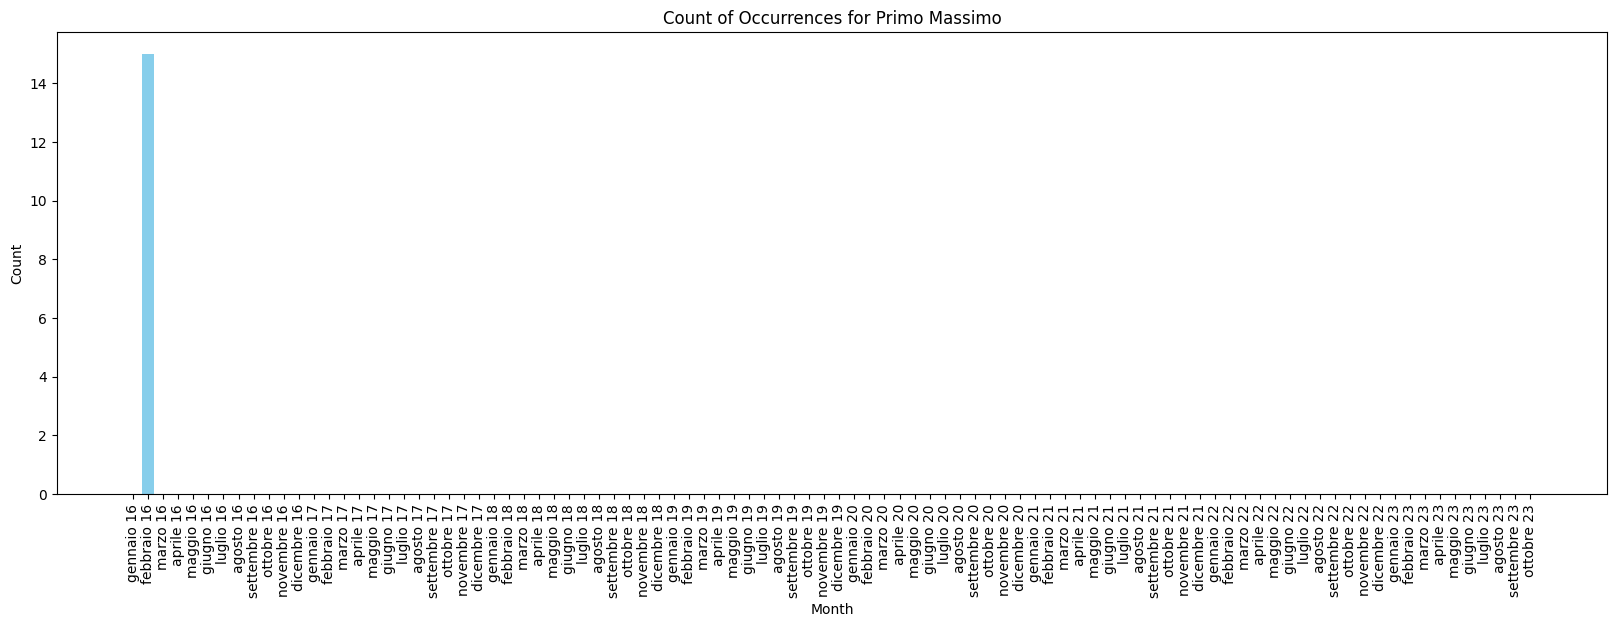

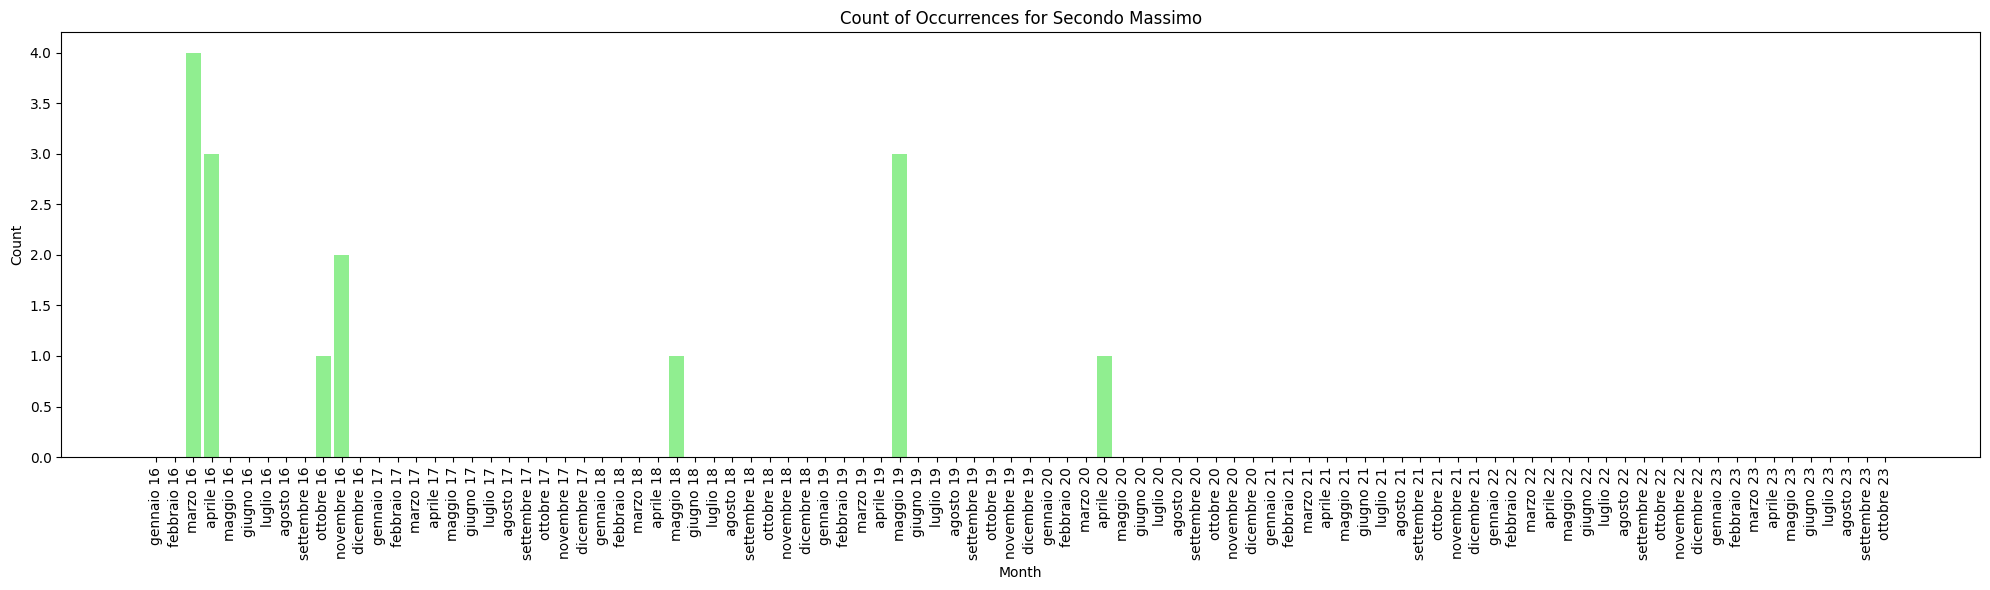

In [38]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Define the order of months
month_order = [
    'gennaio 16', 'febbraio 16', 'marzo 16', 'aprile 16', 'maggio 16', 'giugno 16', 'luglio 16', 'agosto 16',
    'settembre 16', 'ottobre 16', 'novembre 16', 'dicembre 16', 'gennaio 17', 'febbraio 17', 'marzo 17',
    'aprile 17', 'maggio 17', 'giugno 17', 'luglio 17', 'agosto 17', 'settembre 17', 'ottobre 17', 'novembre 17',
    'dicembre 17', 'gennaio 18', 'febbraio 18', 'marzo 18', 'aprile 18', 'maggio 18', 'giugno 18', 'luglio 18',
    'agosto 18', 'settembre 18', 'ottobre 18', 'novembre 18', 'dicembre 18', 'gennaio 19', 'febbraio 19', 'marzo 19',
    'aprile 19', 'maggio 19', 'giugno 19', 'luglio 19', 'agosto 19', 'settembre 19', 'ottobre 19', 'novembre 19',
    'dicembre 19', 'gennaio 20', 'febbraio 20', 'marzo 20', 'aprile 20', 'maggio 20', 'giugno 20', 'luglio 20',
    'agosto 20', 'settembre 20', 'ottobre 20', 'novembre 20', 'dicembre 20', 'gennaio 21', 'febbraio 21', 'marzo 21',
    'aprile 21', 'maggio 21', 'giugno 21', 'luglio 21', 'agosto 21', 'settembre 21', 'ottobre 21', 'novembre 21',
    'dicembre 21', 'gennaio 22', 'febbraio 22', 'marzo 22', 'aprile 22', 'maggio 22', 'giugno 22', 'luglio 22',
    'agosto 22', 'settembre 22', 'ottobre 22', 'novembre 22', 'dicembre 22', 'gennaio 23', 'febbraio 23', 'marzo 23',
    'aprile 23', 'maggio 23', 'giugno 23', 'luglio 23', 'agosto 23', 'settembre 23', 'ottobre 23'
]

# Initialize Counters for 'Primo massimo' and 'Secondo massimo'
primo_massimo_counter = Counter()
secondo_massimo_counter = Counter()

# Iterate through the DataFrame
for index, row in df_secondmodel_firsthalf.iterrows():
    primo_massimo_counter[row['Primo massimo']] += 1
    secondo_massimo_counter[row['Secondo massimo']] += 1

# Convert the Counter objects to dictionaries
primo_massimo_dict = dict(primo_massimo_counter)
secondo_massimo_dict = dict(secondo_massimo_counter)

# Create DataFrames from the dictionaries
primo_massimo_df = pd.DataFrame(list(primo_massimo_dict.items()), columns=['Month', 'Count'])
secondo_massimo_df = pd.DataFrame(list(secondo_massimo_dict.items()), columns=['Month', 'Count'])

# Set the 'Month' column as the index
primo_massimo_df.set_index('Month', inplace=True)
secondo_massimo_df.set_index('Month', inplace=True)

# Reindex to include all months in the specified order
primo_massimo_df = primo_massimo_df.reindex(month_order)
secondo_massimo_df = secondo_massimo_df.reindex(month_order)

# Fill NaN values with 0
primo_massimo_df.fillna(0, inplace=True)
secondo_massimo_df.fillna(0, inplace=True)

# Plot the histograms
plt.figure(figsize=(20, 6))
plt.bar(primo_massimo_df.index, primo_massimo_df['Count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Primo Massimo')
plt.xticks(rotation=90)

plt.figure(figsize=(20, 6))
plt.bar(secondo_massimo_df.index, secondo_massimo_df['Count'], color='lightgreen')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Secondo Massimo')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


# Result second half

In [45]:
# Additional data for the second model - second half
data_second = {
    'Id_sensor': [6300, 6817, 6864, 9917, 6408, 6398, 10017, 6330, 6419, 6831,
                  30162, 10451, 9804, 9920, 6276],
    'Primo massimo': ['giugno 20', 'novembre 20', 'giugno 20', 'ottobre 20', 'maggio 23',
                      'ottobre 20', 'maggio 23', 'giugno 20', 'maggio 23', 'novembre 20',
                      'ottobre 20', 'maggio 23', 'giugno 20', 'maggio 23', 'giugno 20'],
    'Secondo massimo': ['ottobre 20', 'ottobre 20', 'novembre 20', 'giugno 20', 'giugno 20',
                        'novembre 20', 'giugno 23', 'maggio 23', 'giugno 20', 'ottobre 20',
                        'giugno 23', 'giugno 23', 'ottobre 20', 'giugno 23', 'maggio 23']
}

# Create DataFrame from the second set of additional data
df_secondmodel_secondhalf = pd.DataFrame(data_second)

# Display the additional DataFrame for the second model - second half
print(df_secondmodel_secondhalf)


    Id_sensor Primo massimo Secondo massimo
0        6300     giugno 20      ottobre 20
1        6817   novembre 20      ottobre 20
2        6864     giugno 20     novembre 20
3        9917    ottobre 20       giugno 20
4        6408     maggio 23       giugno 20
5        6398    ottobre 20     novembre 20
6       10017     maggio 23       giugno 23
7        6330     giugno 20       maggio 23
8        6419     maggio 23       giugno 20
9        6831   novembre 20      ottobre 20
10      30162    ottobre 20       giugno 23
11      10451     maggio 23       giugno 23
12       9804     giugno 20      ottobre 20
13       9920     maggio 23       giugno 23
14       6276     giugno 20       maggio 23


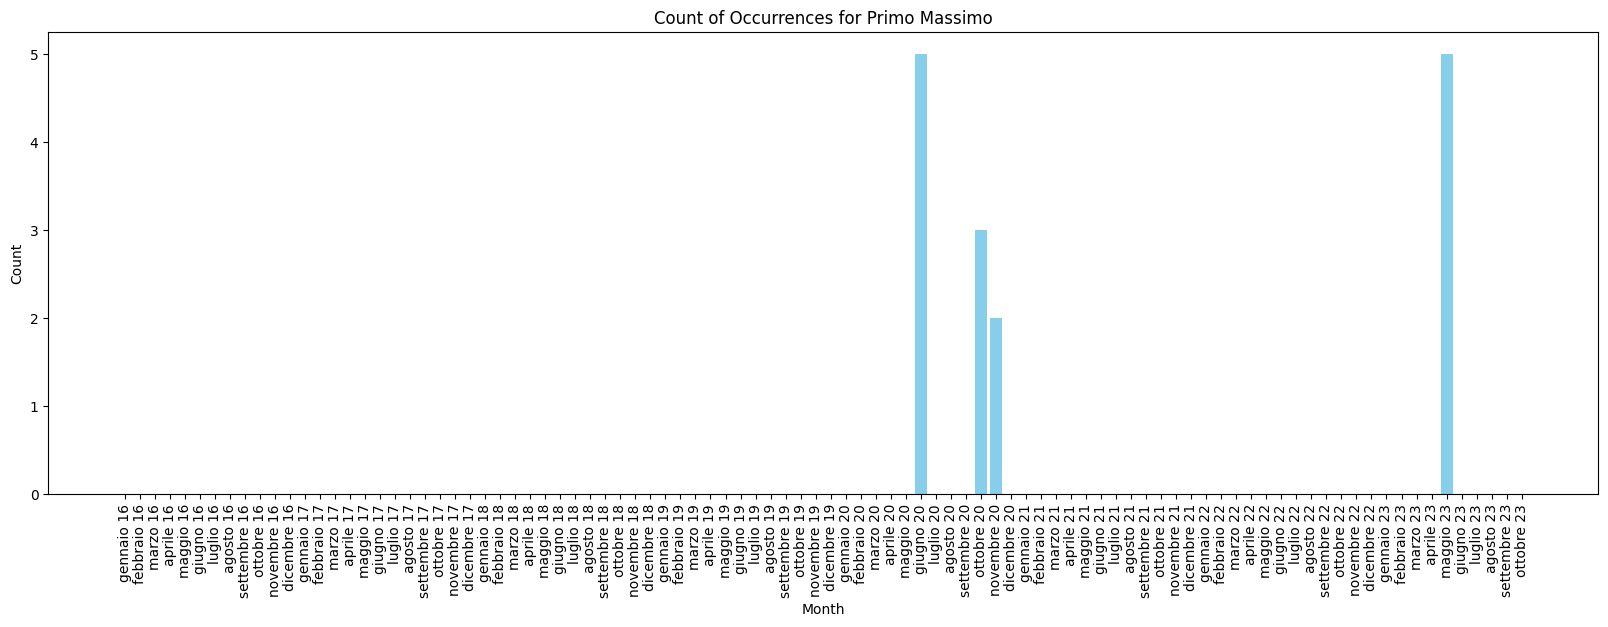

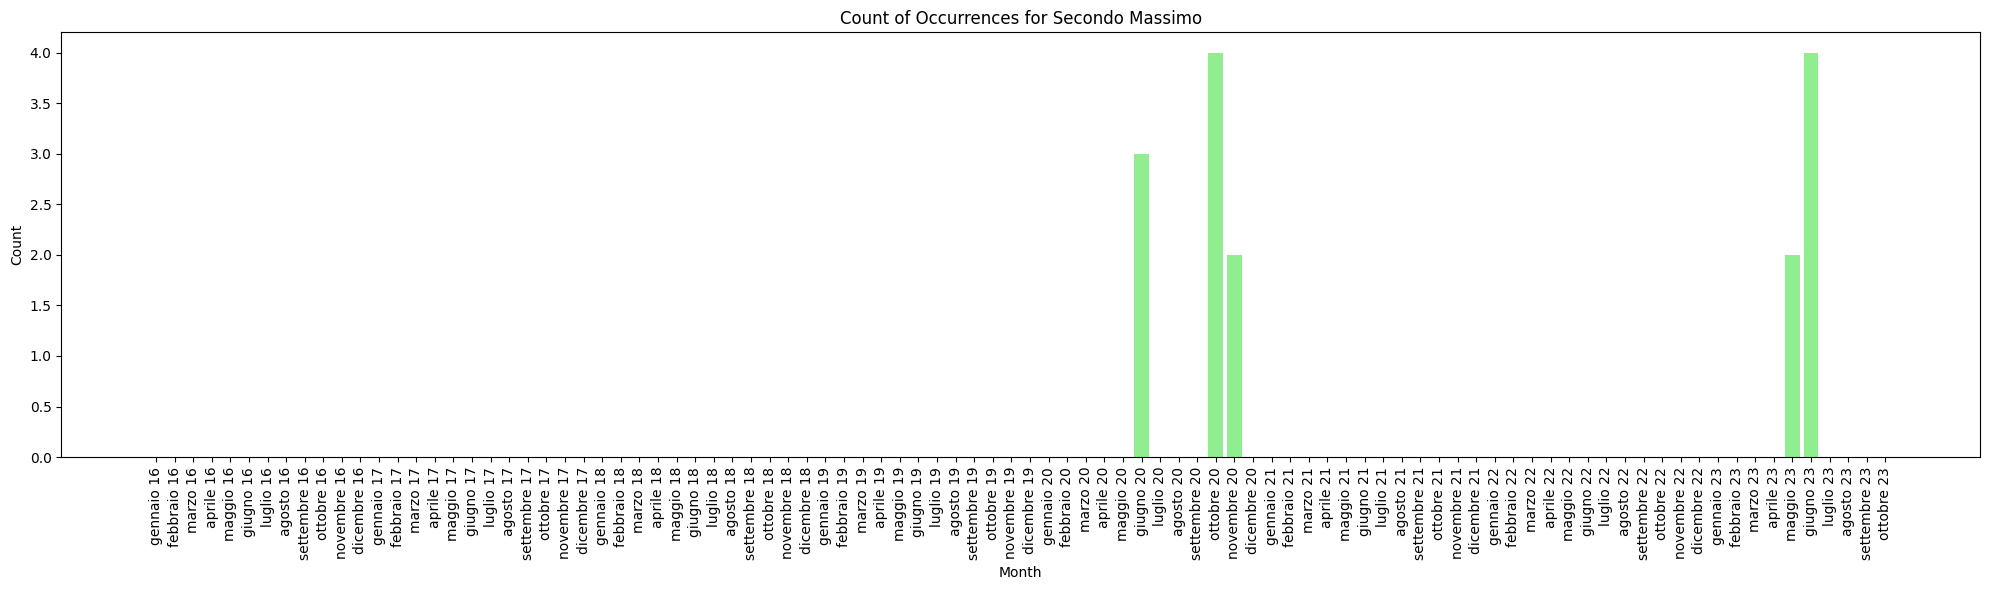

In [46]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Define the order of months
month_order = [
    'gennaio 16', 'febbraio 16', 'marzo 16', 'aprile 16', 'maggio 16', 'giugno 16', 'luglio 16', 'agosto 16',
    'settembre 16', 'ottobre 16', 'novembre 16', 'dicembre 16', 'gennaio 17', 'febbraio 17', 'marzo 17',
    'aprile 17', 'maggio 17', 'giugno 17', 'luglio 17', 'agosto 17', 'settembre 17', 'ottobre 17', 'novembre 17',
    'dicembre 17', 'gennaio 18', 'febbraio 18', 'marzo 18', 'aprile 18', 'maggio 18', 'giugno 18', 'luglio 18',
    'agosto 18', 'settembre 18', 'ottobre 18', 'novembre 18', 'dicembre 18', 'gennaio 19', 'febbraio 19', 'marzo 19',
    'aprile 19', 'maggio 19', 'giugno 19', 'luglio 19', 'agosto 19', 'settembre 19', 'ottobre 19', 'novembre 19',
    'dicembre 19', 'gennaio 20', 'febbraio 20', 'marzo 20', 'aprile 20', 'maggio 20', 'giugno 20', 'luglio 20',
    'agosto 20', 'settembre 20', 'ottobre 20', 'novembre 20', 'dicembre 20', 'gennaio 21', 'febbraio 21', 'marzo 21',
    'aprile 21', 'maggio 21', 'giugno 21', 'luglio 21', 'agosto 21', 'settembre 21', 'ottobre 21', 'novembre 21',
    'dicembre 21', 'gennaio 22', 'febbraio 22', 'marzo 22', 'aprile 22', 'maggio 22', 'giugno 22', 'luglio 22',
    'agosto 22', 'settembre 22', 'ottobre 22', 'novembre 22', 'dicembre 22', 'gennaio 23', 'febbraio 23', 'marzo 23',
    'aprile 23', 'maggio 23', 'giugno 23', 'luglio 23', 'agosto 23', 'settembre 23', 'ottobre 23'
]

# Initialize Counters for 'Primo massimo' and 'Secondo massimo'
primo_massimo_counter = Counter()
secondo_massimo_counter = Counter()

# Iterate through the DataFrame
for index, row in df_secondmodel_secondhalf.iterrows():
    primo_massimo_counter[row['Primo massimo']] += 1
    secondo_massimo_counter[row['Secondo massimo']] += 1

# Convert the Counter objects to dictionaries
primo_massimo_dict = dict(primo_massimo_counter)
secondo_massimo_dict = dict(secondo_massimo_counter)

# Create DataFrames from the dictionaries
primo_massimo_df = pd.DataFrame(list(primo_massimo_dict.items()), columns=['Month', 'Count'])
secondo_massimo_df = pd.DataFrame(list(secondo_massimo_dict.items()), columns=['Month', 'Count'])

# Set the 'Month' column as the index
primo_massimo_df.set_index('Month', inplace=True)
secondo_massimo_df.set_index('Month', inplace=True)

# Reindex to include all months in the specified order
primo_massimo_df = primo_massimo_df.reindex(month_order)
secondo_massimo_df = secondo_massimo_df.reindex(month_order)

# Fill NaN values with 0
primo_massimo_df.fillna(0, inplace=True)
secondo_massimo_df.fillna(0, inplace=True)

# Plot the histograms
plt.figure(figsize=(20, 6))
plt.bar(primo_massimo_df.index, primo_massimo_df['Count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Primo Massimo')
plt.xticks(rotation=90)

plt.figure(figsize=(20, 6))
plt.bar(secondo_massimo_df.index, secondo_massimo_df['Count'], color='lightgreen')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Secondo Massimo')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


# Result all time series

In [47]:
# Additional data
data = {
    'Id_sensor': [6220, 9918, 10095, 6208, 6356, 10037, 10165, 6402, 6326, 30162,
                  10431, 10329, 10285, 6276, 6845, 6338, 6212, 10457, 9920],
    'Primo massimo': ['maggio 18', 'maggio 23', 'aprile 16', 'febbraio 16', 'febbraio 16',
                      'maggio 23', 'aprile 22', 'maggio 19', 'maggio 23', 'febbraio 16',
                      'maggio 23', 'maggio 23', 'giugno 23', 'febbraio 16', 'giugno 23',
                      'maggio 23', 'febbraio 16', 'maggio 22', 'maggio 23'],
    'Secondo massimo': ['giugno 18', 'giugno 23', 'marzo 16', 'giugno 23', 'maggio 23',
                        'giugno 23', 'maggio 22', 'giugno 19', 'febbraio 16', 'giugno 23',
                        'aprile 23', 'giugno 23', 'maggio 23', 'maggio 23', 'luglio 23',
                        'febbraio 16', 'maggio 19', 'febbraio 16', 'giugno 23']
}

# Create DataFrame from data
df = pd.DataFrame(data)

# Display the additional DataFrame
print(df)


    Id_sensor Primo massimo Secondo massimo
0        6220     maggio 18       giugno 18
1        9918     maggio 23       giugno 23
2       10095     aprile 16        marzo 16
3        6208   febbraio 16       giugno 23
4        6356   febbraio 16       maggio 23
5       10037     maggio 23       giugno 23
6       10165     aprile 22       maggio 22
7        6402     maggio 19       giugno 19
8        6326     maggio 23     febbraio 16
9       30162   febbraio 16       giugno 23
10      10431     maggio 23       aprile 23
11      10329     maggio 23       giugno 23
12      10285     giugno 23       maggio 23
13       6276   febbraio 16       maggio 23
14       6845     giugno 23       luglio 23
15       6338     maggio 23     febbraio 16
16       6212   febbraio 16       maggio 19
17      10457     maggio 22     febbraio 16
18       9920     maggio 23       giugno 23


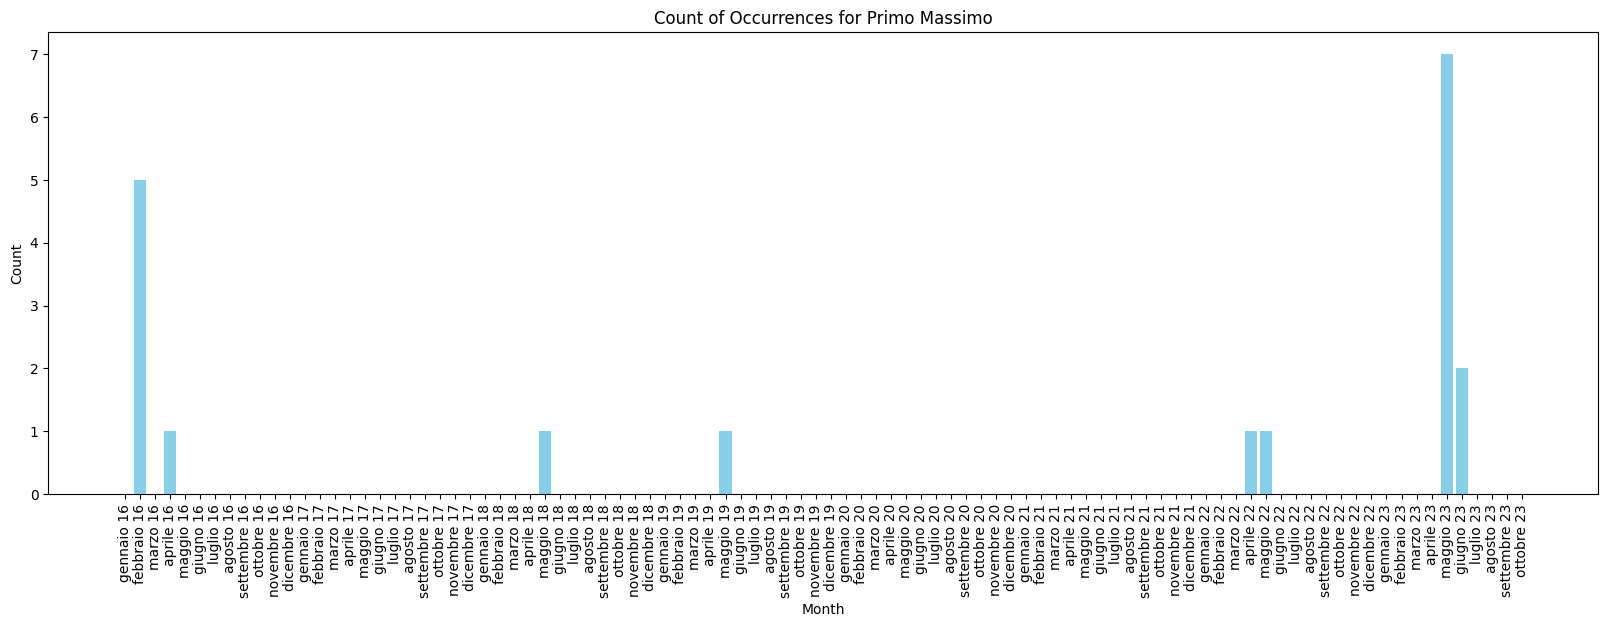

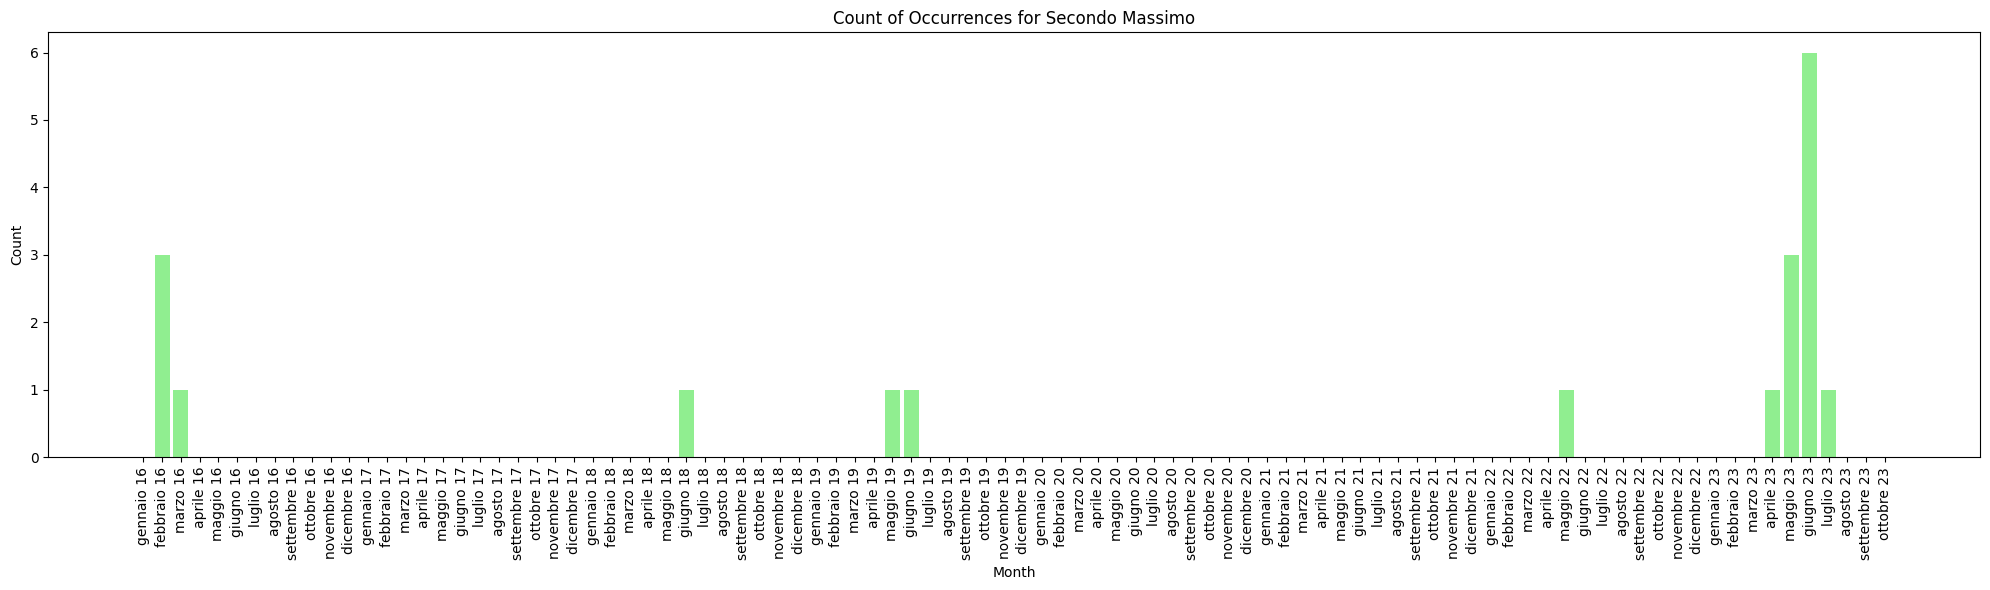

In [48]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Define the order of months
month_order = [
    'gennaio 16', 'febbraio 16', 'marzo 16', 'aprile 16', 'maggio 16', 'giugno 16', 'luglio 16', 'agosto 16',
    'settembre 16', 'ottobre 16', 'novembre 16', 'dicembre 16', 'gennaio 17', 'febbraio 17', 'marzo 17',
    'aprile 17', 'maggio 17', 'giugno 17', 'luglio 17', 'agosto 17', 'settembre 17', 'ottobre 17', 'novembre 17',
    'dicembre 17', 'gennaio 18', 'febbraio 18', 'marzo 18', 'aprile 18', 'maggio 18', 'giugno 18', 'luglio 18',
    'agosto 18', 'settembre 18', 'ottobre 18', 'novembre 18', 'dicembre 18', 'gennaio 19', 'febbraio 19', 'marzo 19',
    'aprile 19', 'maggio 19', 'giugno 19', 'luglio 19', 'agosto 19', 'settembre 19', 'ottobre 19', 'novembre 19',
    'dicembre 19', 'gennaio 20', 'febbraio 20', 'marzo 20', 'aprile 20', 'maggio 20', 'giugno 20', 'luglio 20',
    'agosto 20', 'settembre 20', 'ottobre 20', 'novembre 20', 'dicembre 20', 'gennaio 21', 'febbraio 21', 'marzo 21',
    'aprile 21', 'maggio 21', 'giugno 21', 'luglio 21', 'agosto 21', 'settembre 21', 'ottobre 21', 'novembre 21',
    'dicembre 21', 'gennaio 22', 'febbraio 22', 'marzo 22', 'aprile 22', 'maggio 22', 'giugno 22', 'luglio 22',
    'agosto 22', 'settembre 22', 'ottobre 22', 'novembre 22', 'dicembre 22', 'gennaio 23', 'febbraio 23', 'marzo 23',
    'aprile 23', 'maggio 23', 'giugno 23', 'luglio 23', 'agosto 23', 'settembre 23', 'ottobre 23'
]

# Initialize Counters for 'Primo massimo' and 'Secondo massimo'
primo_massimo_counter = Counter()
secondo_massimo_counter = Counter()

# Iterate through the DataFrame
for index, row in df.iterrows():
    primo_massimo_counter[row['Primo massimo']] += 1
    secondo_massimo_counter[row['Secondo massimo']] += 1

# Convert the Counter objects to dictionaries
primo_massimo_dict = dict(primo_massimo_counter)
secondo_massimo_dict = dict(secondo_massimo_counter)

# Create DataFrames from the dictionaries
primo_massimo_df = pd.DataFrame(list(primo_massimo_dict.items()), columns=['Month', 'Count'])
secondo_massimo_df = pd.DataFrame(list(secondo_massimo_dict.items()), columns=['Month', 'Count'])

# Set the 'Month' column as the index
primo_massimo_df.set_index('Month', inplace=True)
secondo_massimo_df.set_index('Month', inplace=True)

# Reindex to include all months in the specified order
primo_massimo_df = primo_massimo_df.reindex(month_order)
secondo_massimo_df = secondo_massimo_df.reindex(month_order)

# Fill NaN values with 0
primo_massimo_df.fillna(0, inplace=True)
secondo_massimo_df.fillna(0, inplace=True)

# Plot the histograms
plt.figure(figsize=(20, 6))
plt.bar(primo_massimo_df.index, primo_massimo_df['Count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Primo Massimo')
plt.xticks(rotation=90)

plt.figure(figsize=(20, 6))
plt.bar(secondo_massimo_df.index, secondo_massimo_df['Count'], color='lightgreen')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Secondo Massimo')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
